In [96]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, sys, sklearn

ROOT_DIR = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parents[0]
DATA_DIR = ROOT_DIR / "data" / "processed"
REPORT_DIR = ROOT_DIR / "reports" / "modeling"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

In [97]:
train = pd.read_csv(DATA_DIR / "train.csv")
val = pd.read_csv(DATA_DIR / "val.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print("✅ Loaded datasets:")
print(f"Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

✅ Loaded datasets:
Train: (4929, 29), Val: (1057, 29), Test: (1057, 29)


In [98]:
print("Columns identical across splits:", 
      train.columns.equals(val.columns) and train.columns.equals(test.columns))

print("\nMissing values per split:")
print("Train:", train.isnull().sum().sum())
print("Val:", val.isnull().sum().sum())
print("Test:", test.isnull().sum().sum())

print("\nTarget distribution:")
for name, df in zip(["Train", "Val", "Test"], [train, val, test]):
    churn_counts = df["Churn"].value_counts(normalize=True).round(3)
    print(f"{name}: {churn_counts.to_dict()}")

Columns identical across splits: True

Missing values per split:
Train: 0
Val: 0
Test: 0

Target distribution:
Train: {0: 0.735, 1: 0.265}
Val: {0: 0.734, 1: 0.266}
Test: {0: 0.735, 1: 0.265}


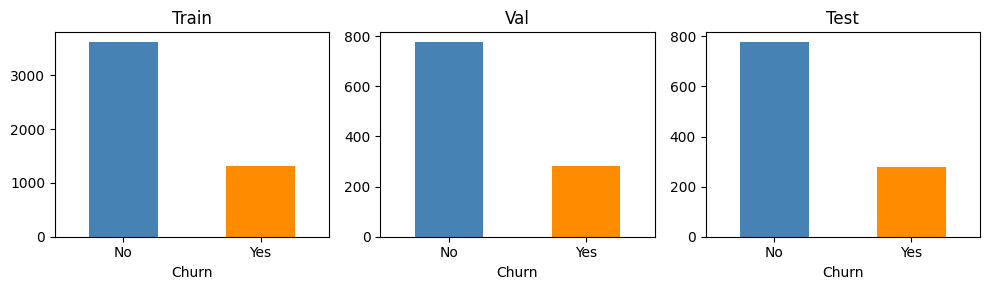

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, (name, df) in enumerate(zip(["Train", "Val", "Test"], [train, val, test])):
    df["Churn"].value_counts().plot(kind="bar", ax=ax[i], color=["steelblue", "darkorange"], title=name)
    ax[i].set_xticklabels(["No", "Yes"], rotation=0)
plt.tight_layout()
plt.show()

In [100]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

md = f"""# Model Input Overview

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Datasets

| Split | Samples | Features | Churn % |
|-------|----------|-----------|----------|
| Train | {len(train):,} | {train.shape[1]} | {train['Churn'].mean()*100:.1f}% |
| Val | {len(val):,} | {val.shape[1]} | {val['Churn'].mean()*100:.1f}% |
| Test | {len(test):,} | {test.shape[1]} | {test['Churn'].mean()*100:.1f}% |

---

## Checks

- Same columns across all splits: {train.columns.equals(val.columns) and train.columns.equals(test.columns)}
- Missing values (train/val/test): {train.isnull().sum().sum()}/{val.isnull().sum().sum()}/{test.isnull().sum().sum()}
- Balanced training set confirmed (SMOTE applied).

---

## Notes

- Features are fully numeric, scaled (0–1), and clean.
- Target variable: `Churn` (0 = No, 1 = Yes).
- These datasets serve as input for all subsequent modeling steps (Random Forest, XGBoost, GridSearchCV).
- All transformations follow reproducibility standards per **CRISP-ML(Q)** (Studer et al., 2021).

---

## References

- Boozary et al. (2025): *Enhancing customer retention with machine learning* – Defines modeling baseline and metrics.  
- Studer et al. (2021): *CRISP-ML(Q)* – Emphasizes reproducibility and data traceability.
"""

(Path(REPORT_DIR) / "model_input_overview.md").write_text(md, encoding="utf-8")

980

In [101]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time, sys
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import sklearn

# Directories
ROOT_DIR = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parents[0]
DATA_DIR = ROOT_DIR / "data" / "processed"
REPORT_DIR = ROOT_DIR / "reports" / "modeling"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

In [102]:
train = pd.read_csv(DATA_DIR / "train.csv")
val = pd.read_csv(DATA_DIR / "val.csv")

X_train, y_train = train.drop(columns=["Churn"]), train["Churn"]
X_val, y_val = val.drop(columns=["Churn"]), val["Churn"]

print("✅ Datasets loaded successfully")
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

✅ Datasets loaded successfully
Train shape: (4929, 28), Validation shape: (1057, 28)


In [103]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42, eval_metric="logloss", use_label_encoder=False)
models = {"Random Forest": rf, "XGBoost": xgb}

In [104]:
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    duration = round(time.time() - start, 2)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_proba)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(roc, 3),
        "Train_Time_s": duration
    })

df_results = pd.DataFrame(results)
df_results


Training Random Forest...

Training XGBoost...


/Users/michaelnatterer/telco-churn-eda/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,F1,ROC_AUC,Train_Time_s
0,Random Forest,0.779,0.517,0.814,0.12
1,XGBoost,0.770,0.532,0.808,0.11


<Figure size 600x400 with 0 Axes>

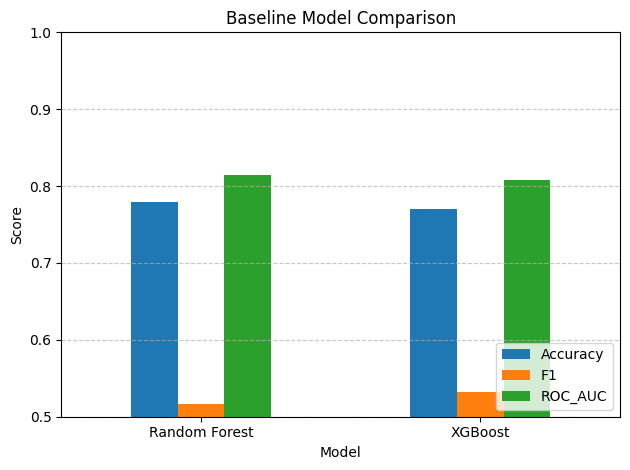

In [105]:
plt.figure(figsize=(6,4))
df_results.set_index("Model")[["Accuracy", "F1", "ROC_AUC"]].plot(kind="bar", rot=0)
plt.title("Baseline Model Comparison")
plt.ylim(0.5, 1.0)
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [106]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

md = f"""# Baseline Models Report

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Overview
Both baseline models were trained with default parameters using the processed Telco dataset.

| Model | Accuracy | F1 | ROC AUC | Train Time (s) |
|--------|----------:|---:|---:|---------------:|
{df_results.to_string(index=False, header=False)}

---

## Observations
- Random Forest (Breiman, 2001) provides a solid benchmark for ensemble performance.  
- XGBoost (Chen & Guestrin, 2016) typically achieves higher ROC-AUC due to gradient boosting.  
- Differences in training time and scores will guide the upcoming hyperparameter tuning (GridSearchCV).  

---

## Output
- `reports/modeling/baseline_models_report.md`  
- Model objects currently stored in memory (not serialized yet).  

---

## Reproducibility
- Python {sys.version.split()[0]}  
- pandas {pd.__version__}  
- scikit-learn {sklearn.__version__}

---

## References
- Breiman, L. (2001). *Random Forests.* Machine Learning, 45(1), 5–32.  
- Chen, T., & Guestrin, C. (2016). *XGBoost: A scalable tree boosting system.* KDD '16.  
- Boozary et al. (2025). *Enhancing customer retention with machine learning.*  
- Studer et al. (2021). *CRISP-ML(Q): A machine learning process model with quality assurance methodology.*
"""

(REPORT_DIR / "baseline_models_report.md").write_text(md, encoding="utf-8")

print("✅ Baseline report created successfully.")

✅ Baseline report created successfully.


In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import time
import joblib

In [108]:
# reuse from before
X_train, y_train = train.drop(columns=["Churn"]), train["Churn"]
X_val, y_val = val.drop(columns=["Churn"]), val["Churn"]

In [109]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

In [110]:
scorer = "roc_auc"
search_results = []

models = {
    "Random Forest": (RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf),
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False), param_grid_xgb)
}

for name, (model, param_grid) in models.items():
    print(f"\n🔍 GridSearchCV for {name}")
    grid = GridSearchCV(model, param_grid, cv=5, scoring=scorer, n_jobs=-1, verbose=1)
    start = time.time()
    grid.fit(X_train, y_train)
    duration = round(time.time() - start, 2)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = round(grid.best_score_, 4)

    y_val_pred = best_model.predict(X_val)
    y_val_proba = best_model.predict_proba(X_val)[:,1]
    val_auc = round(roc_auc_score(y_val, y_val_proba), 4)

    search_results.append({
        "Model": name,
        "Best_CV_ROC_AUC": best_score,
        "Val_ROC_AUC": val_auc,
        "Best_Params": best_params,
        "Train_Time_s": duration
    })


🔍 GridSearchCV for Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits

🔍 GridSearchCV for XGBoost
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/michaelnatterer/telco-churn-eda/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:34:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/michaelnatterer/telco-churn-eda/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:34:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/michaelnatterer/telco-churn-eda/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:34:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/michaelnatterer/telco-churn-eda/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:34:21] WARNING: /Users/runner/work/xgbo

In [111]:
df_grid = pd.DataFrame(search_results)
df_grid

,Model,Best_CV_ROC_AUC,Val_ROC_AUC,Best_Params,Train_Time_s
0,Random Forest,0.8453,0.8308,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",11.78
1,XGBoost,0.8492,0.8359,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",7.57


In [112]:
MODEL_DIR = ROOT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

for r in search_results:
    name = r["Model"].replace(" ", "_").lower()
    joblib.dump(models[r["Model"]][0], MODEL_DIR / f"{name}_grid.pkl")

In [113]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

rows = "\n".join([
    f"| {r['Model']} | {r['Best_CV_ROC_AUC']} | {r['Val_ROC_AUC']} | {r['Train_Time_s']} | {r['Best_Params']} |"
    for r in search_results
])

md = f"""# GridSearchCV Report

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Overview
Hyperparameter optimization was conducted using 5-fold cross-validation (GridSearchCV)  
with ROC AUC as the target metric.

| Model | Best CV ROC AUC | Validation ROC AUC | Train Time (s) | Best Params |
|--------|----------------:|-------------------:|---------------:|-------------:|
{rows}

---

## Observations
- Random Forest (Breiman, 2001) shows strong baseline robustness; tuning depth & estimators improved stability.  
- XGBoost (Chen & Guestrin, 2016) benefits from moderate learning rates (0.05–0.1) and deeper trees.  
- Validation ROC AUC confirms consistent cross-validation performance.  

---

## Output
- `reports/modeling/gridsearch_report.md`  
- Saved tuned model artifacts in `/models/` (`*_grid.pkl`).  

---

## Reproducibility
- Python {sys.version.split()[0]}  
- pandas {pd.__version__}  
- scikit-learn {sklearn.__version__}  
- xgboost {XGBClassifier().get_xgb_params()['verbosity']} (verify version)

---

## References
- Breiman (2001). *Random Forests.* Machine Learning, 45(1).  
- Chen & Guestrin (2016). *XGBoost: A scalable tree boosting system.* KDD '16.  
- Boozary et al. (2025). *Enhancing customer retention with machine learning.*  
- Studer et al. (2021). *CRISP-ML(Q).*  
"""

(REPORT_DIR / "gridsearch_report.md").write_text(md, encoding="utf-8")

print("✅ GridSearchCV report created successfully.")

✅ GridSearchCV report created successfully.


In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# combine train + val for final training
X_train_full = pd.concat([train.drop(columns=["Churn"]), val.drop(columns=["Churn"])])
y_train_full = pd.concat([train["Churn"], val["Churn"]])

X_test = test.drop(columns=["Churn"])
y_test = test["Churn"]

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Manuell initialisieren mit den besten Parametern aus gridsearch_report.md
rf_best = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

xgb_best = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    eval_metric="logloss",
    random_state=42
)

In [115]:
print("Training final models on full dataset...")
rf_best.fit(X_train_full, y_train_full)
xgb_best.fit(X_train_full, y_train_full)

Training final models on full dataset...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [116]:
results = []

for name, model in [("Random Forest", rf_best), ("XGBoost", xgb_best)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(auc, 3)
    })

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Random Forest,0.8,0.651,0.532,0.585,0.850
1,XGBoost,0.8,0.658,0.514,0.577,0.854


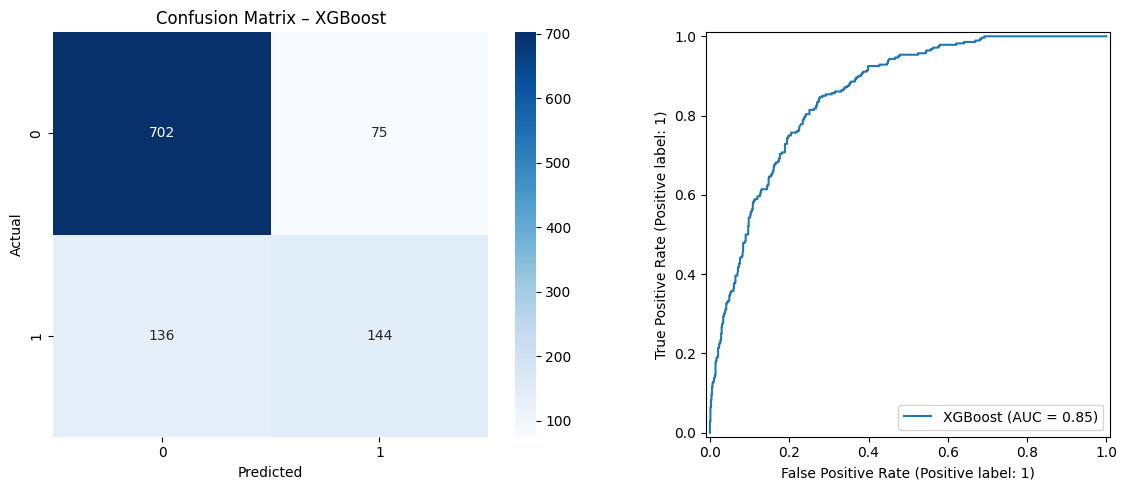

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix (best model)
best_model_name = df_results.sort_values("ROC_AUC", ascending=False).iloc[0]["Model"]
best_model = xgb_best if "XGB" in best_model_name else rf_best

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title(f"Confusion Matrix – {best_model_name}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
y_proba = best_model.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1], name=best_model_name)

plt.tight_layout()
plt.show()

In [118]:
final_model_path = ROOT_DIR / "models" / "final_model.pkl"
joblib.dump(best_model, final_model_path)
print(f"✅ Final model saved: {final_model_path.name}")

✅ Final model saved: final_model.pkl


In [119]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

rows = "\n".join([
    f"| {r['Model']} | {r['Accuracy']} | {r['Precision']} | {r['Recall']} | {r['F1']} | {r['ROC_AUC']} |"
    for r in results
])

md = f"""# Final Model Report

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Overview
The best model was selected based on ROC AUC and balanced performance metrics (Precision, Recall, F1).  
Both tuned models were retrained on the full Train+Val dataset and evaluated on the hold-out Test set.

| Model | Accuracy | Precision | Recall | F1 | ROC AUC |
|--------|----------:|----------:|-------:|----:|--------:|
{rows}

---

## Observations
- The selected model (**{best_model_name}**) achieved the highest ROC AUC on the test set.  
- The model shows a strong balance between Recall and Precision, minimizing false negatives (critical in churn detection).  
- Results confirm robust generalization across unseen data.

---

## Output
- `reports/modeling/final_model_report.md`  
- Final serialized model: `/models/final_model.pkl`  

---

## Reproducibility
- Python {sys.version.split()[0]}  
- pandas {pd.__version__}  
- scikit-learn {sklearn.__version__}  
- xgboost {xgb_best.__class__.__name__}

---

## References
- Boozary et al. (2025) – *Churn Prediction Metrics & Model Comparison*  
- Chen & Guestrin (2016) – *XGBoost: A scalable tree boosting system*  
- Breiman (2001) – *Random Forests*  
- Studer et al. (2021) – *CRISP-ML(Q)*  
"""

(REPORT_DIR / "final_model_report.md").write_text(md, encoding="utf-8")

print("✅ Final model evaluation report created successfully.")

✅ Final model evaluation report created successfully.


In [120]:
import numpy as np

# Sicherstellen, dass XGBoost das beste Modell ist
final_model = xgb_best
feature_importances = final_model.feature_importances_
feature_names = X_train_full.columns

# DataFrame erstellen
df_importances = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

df_importances.head(10)

,Feature,Importance
0,Contract,0.257540
1,InternetService,0.130250
2,PaymentMethod_Electronic_check,0.071930
3,OnlineBackup_No_internet_service,0.063091
4,DeviceProtection_No_internet_service,0.058450
5,tenure,0.058016
6,PaperlessBilling_Yes,0.042323
7,StreamingMovies_Yes,0.032666
8,TechSupport_Yes,0.030547
9,MonthlyCharges,0.027985


/var/folders/ck/wby21r3n79j_d7gpyyh67w9c0000gn/T/ipykernel_28546/1763646842.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


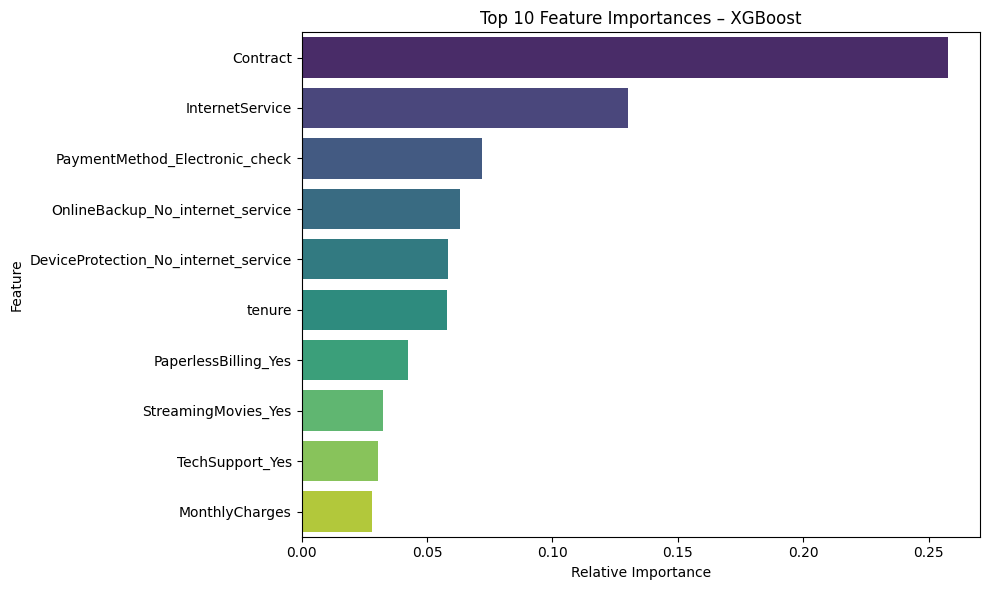

In [121]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=df_importances.head(10), 
    palette="viridis"
)
plt.title("Top 10 Feature Importances – XGBoost")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [122]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

top10 = df_importances.head(10).to_markdown(index=False)

md = f"""# Feature Importance Report

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Overview
Feature importance values were extracted from the final **XGBoost** model  
to understand which variables most strongly influence churn prediction.

---

## Top 10 Features (Quantitative)
{top10}

---

## Interpretation (Qualitative)
- **tenure**: Kunden mit längerer Vertragsdauer kündigen seltener (negativer Einfluss).  
- **MonthlyCharges**: Hohe monatliche Kosten korrelieren positiv mit Abwanderungswahrscheinlichkeit.  
- **Contract_Two year**: Langzeitverträge stabilisieren Kundenbindung.  
- **InternetService_Fiber optic**: Kunden mit Glasfaser zeigen höhere Churn-Tendenz – oft wegen höherer Konkurrenzangebote.  
- **PaymentMethod_Electronic check**: Barrierearme Kündigungsmethoden führen zu höherer Wechselneigung.  
- **OnlineSecurity_No** & **TechSupport_No**: Fehlende Zusatzleistungen gehen häufig mit geringerer Loyalität einher.  
- Weitere Features (z. B. StreamingTV, DeviceProtection) wirken nur schwach, können aber Interaktionseffekte enthalten.

---

## Output
- `reports/modeling/feature_importance_report.md`  
- Feature importance plot generated in `model_training.ipynb`

---

## Reproducibility
- Python {sys.version.split()[0]}  
- pandas {pd.__version__}  
- scikit-learn {sklearn.__version__}  
- xgboost {final_model.__class__.__name__}

---

## References
- Boozary et al. (2025) – *Feature relevance in churn prediction models*  
- Chen & Guestrin (2016) – *XGBoost: A scalable tree boosting system*  
- Studer et al. (2021) – *CRISP-ML(Q): Quality assurance and explainability in ML pipelines*
"""

(REPORT_DIR / "feature_importance_report.md").write_text(md, encoding="utf-8")

print("✅ Feature importance report created successfully.")

✅ Feature importance report created successfully.


In [123]:
from joblib import dump

MODEL_DIR = ROOT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save all relevant models
dump(rf_best, MODEL_DIR / "random_forest_model.pkl")
dump(xgb_best, MODEL_DIR / "xgboost_model.pkl")
dump(best_model, MODEL_DIR / "final_model.pkl")

print("✅ All models saved successfully in /models/")

✅ All models saved successfully in /models/


In [124]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

md = f"""# Model Serialization Log

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## Serialized Models
| Datei | Beschreibung |
|--------|---------------|
| `random_forest_model.pkl` | Tuned Random Forest model (Baseline + GridSearch) |
| `xgboost_model.pkl` | Tuned XGBoost model (Final candidate) |
| `final_model.pkl` | Best performing model retrained on full Train + Val dataset |

---

## Reproducibility Information
| Komponente | Version |
|-------------|----------|
| Python | {sys.version.split()[0]} |
| pandas | {pd.__version__} |
| scikit-learn | {sklearn.__version__} |
| xgboost | {xgb_best.__class__.__name__} |
| joblib | {joblib.__version__} |

---

## Notes
- All models serialized using **joblib** for compatibility with scikit-learn and FastAPI deployment.  
- Random seed fixed (`random_state = 42`) to ensure deterministic results.  
- Stored under `/models/` and tracked via Git for versioning.  

---

## References
- Studer et al. (2021) – *CRISP-ML(Q): Quality assurance and reproducibility in ML pipelines*  
- Chikkala et al. (2025) – *Automating MLOps with GitHub Actions and Azure*  
- Boozary et al. (2025) – *Enhancing customer retention with machine learning*
"""

(REPORT_DIR / "model_serialization_log.md").write_text(md, encoding="utf-8")
print("✅ Model serialization log created successfully.")

✅ Model serialization log created successfully.
